In [3]:
from arftools import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy 
from sklearn.metrics.pairwise import rbf_kernel
import random

In [57]:
def mse(datax,datay,w):
    """ retourne la moyenne de l'erreur aux moindres carres """
    return np.mean((np.dot(datax, w.T) - datay)**2)

def mse_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur au moindres carres """
    return np.mean(2 * (np.dot(datax, w.T) - datay))

def hinge(datax,datay,w):
    """ retourn la moyenne de l'erreur hinge """
    return max(0,-datay * w.dot(datax))

def hinge_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur hinge """
    if np.mean(datay * np.dot(datax.T,w.T))<=0:
        return -datay*datax
    else:
        return np.zeros(w.shape)


In [5]:
def filter_data(x, y, a,b):
    datax, datay = np.copy(x), np.copy(y)
    i = np.where(np.logical_or(datay == a, datay == b))[0]
    new_datay= np.array(datay[i])
    new_datay[new_datay == a] = -1
    new_datay[new_datay == b] = 1
    return np.array(datax[i]),new_datay

In [6]:
def filter_dataOne(x, y, a):
    datax, datay = np.copy(x), np.copy(y)
    i = np.where(datay == a)[0]
    new_datay= np.array(datay[i])
    new_datay[new_datay == a] = -1
    return np.array(datax[i]),new_datay

In [7]:
def filter_dataSet(x, y, a):
    datax, datay = np.copy(x), np.copy(y)
    i = np.where(datay != a)[0]
    new_datay= np.array(datay[i])
    new_datay[new_datay != a] = 1
    return np.array(datax[i]),new_datay

In [46]:
def chunks(l, n):
    n = max(1, n)
    result=[]
    for i in range(0, len(l), n):
        result.append(l[i:i+n])
    return result

def add_bias(datax):
    new_dim = np.ones(datax.shape[0]).reshape(-1, 1)
    new_datax=np.hstack((datax, new_dim))
    return new_datax

def gauss(x,datax, sigma):
    x_xdata=x - datax
    result=np.zeros((1,x_xdata.shape[0]))
    i=0
    for norm_s in x_xdata:
        result[0][i]=np.exp(-np.linalg.norm(norm_s, 2)**2 / (2. * sigma**2))
        i+=1
    return result

def projection(datax,kernel,sigma=0):
    if kernel=="bias":
        x1_2 = (datax[:, 0] * datax[:, 0]).reshape(-1, 1)
        x2_2 = (datax[:, 1] * datax[:, 1]).reshape(-1, 1)
        x1x2 = (datax[:, 0] * datax[:, 1]).reshape(-1, 1)
        new_datax=np.hstack((datax, x1_2, x2_2, x1x2))
        return new_datax
    elif kernel=="bias3D":
        x1_2 = (datax[:, 0] * datax[:, 0]).reshape(-1, 1)
        x2_2 = (datax[:, 1] * datax[:, 1]).reshape(-1, 1)
        x1x2 = (2**0.5*(datax[:, 0] * datax[:, 1])).reshape(-1, 1)
        new_datax=np.hstack((x1_2, x2_2, x1x2))
        return new_datax
    elif kernel=="gauss":
        new_datax=np.zeros((1000,1000))
        i=0
        for x in datax:
            new_datax[i:i+1,:]=(gauss(x,datax,sigma))
            i+=1
        return new_datax


In [9]:
d=projection(trainx,'gauss',sigma=0.5)

NameError: name 'trainx' is not defined

In [67]:
d.shape

(1000, 1000)

In [40]:
class Perceptron(object):
    def __init__(self,loss=hinge,loss_g=hinge_g,max_iter=1000,eps=0.01, kernel="bias",sigma=0,typeUp="batch",bins=0):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
            :kernel: noyau du perceptron
        """
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss, loss_g
        self.kernel = kernel
        self.sigma=sigma
        self.bins=bins
        self.typeUp=typeUp
        
    def fit(self,datax,datay,testx=None,testy=None):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        # on transforme datay en vecteur colonne
        datay = datay.reshape(-1,1)
        N = len(datay)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        self.w = np.random.random((1,D))
        self.w_init=copy.deepcopy(self.w)
        data_projected=copy.deepcopy(datax)
        if(self.kernel=='bias') or( self.kernel=='gauss') or (self.kernel=='bias3D') :
            print("kernel  detected:", self.kernel)
            data_projected=self.project_data(copy.deepcopy(datax))
            if (self.kernel=='bias'):
                self.w = np.random.random((1,D+3))
                self.w_init=copy.deepcopy(self.w)
            elif (self.kernel=='gauss'):
                self.w = np.random.random((1,datax.shape[0]))
                self.w_init=copy.deepcopy(self.w)
            elif (self.kernel=='bias3D'):
                self.w = np.random.random((1,D+1))
                self.w_init=copy.deepcopy(self.w)
        if(self.typeUp=='batch'):      
            for i in range(self.max_iter):
                self.w -= self.eps * self.loss_g(data_projected.T, datay, self.w)
        elif(self.typeUp=='stochastique'):
            for i in range(self.max_iter):
                index=random.choice(np.arange(0,data_projected.shape[0],1))
                self.w -= self.eps * self.loss_g(data_projected[index].T, datay[index], self.w)
        elif(self.typeUp=='minibatch'):
            list_shuffle=random.shuffle(np.arange(0,data_projected.shape[0],1),lambda:random.random())
            datax_s=[x for _,x in sorted(zip(list_shuffle,data_projected))]
            datay_s=[x for _,x in sorted(zip(list_shuffle,datay))]
            mini_binsX=chunks(datax_s,N/2)
            mini_binsY=chunks(datay_s,N/2)
            for i in range(len(mini_binsX)):
                for i in range(self.max_iter):
                    self.w -= self.eps * self.loss_g(mini_binsX[i], mini_binsY[i], self.w)
                    

    def predict(self,datax):
        data_projected=copy.deepcopy(datax)
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1)
        if(self.kernel=='bias') or( self.kernel=='gauss') or (self.kernel=='bias3D'):
            data_projected=self.project_data(copy.deepcopy(datax))
        return np.sign(np.dot(data_projected, self.w.T)).reshape(-1)

    def score(self,datax,datay):
        return np.where(self.predict(datax).reshape(-1)==datay,1,0).mean()
    def project_data(self,datax):
        return projection(datax,self.kernel,self.sigma)
    

    

In [11]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def plot_error(datax,datay,f,step=10):
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(datax,datay,w) for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.show()  

In [12]:
def gaussienne(centerx,centery,sigma,nbex,data_type,epsilon):
    xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex/4)),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
    xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),int(nbex/4)),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
    data=np.vstack((xpos,xneg))
    y=np.hstack((np.ones(int(nbex/2)),-np.ones(int(nbex/2))))
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y

In [13]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=0.5)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=0.5)

In [38]:
trainx.T.shape

(2, 1000)

Hinge-Erreur : train 0.994000, test 0.989000


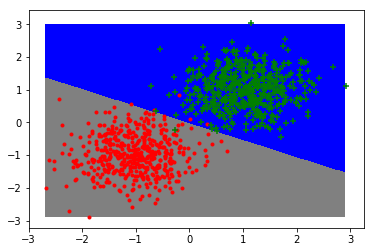

In [62]:
perceptron1 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.1, kernel=None)
perceptron1.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron1.score(trainx,trainy),perceptron1.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron1.predict,200)
plot_data(trainx,trainy)

In [ ]:
plt.plot(perceptron1.lossA, label = "Apprentissage")
plt.plot(perceptron1.lossT, label = "Test")
plt.legend()
plt.show()

MSE-Erreur : train 0.986000, test 0.986000


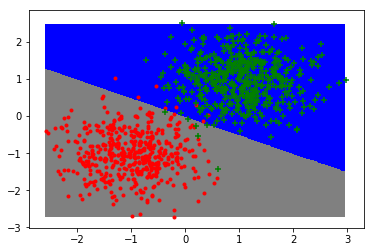

In [94]:
perceptron = Perceptron(mse,mse_g,max_iter=1000,eps=0.1, kernel=None)
perceptron.fit(trainx,trainy)
print("MSE-Erreur : train %f, test %f"% (perceptron.score(trainx,trainy),perceptron.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron.predict,200)
plot_data(trainx,trainy)

Données USPS

In [51]:
datax_train, datay_train = load_usps("USPS_train.txt")
datax_test, datay_test = load_usps("USPS_test.txt")

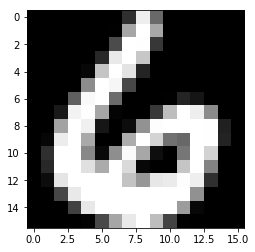

In [57]:
show_usps(datax_train[0])


In [103]:
datax_train69, datay_train69 = filter_data(datax_train, datay_train, 6, 9)
datax_test69, datay_test69= filter_data(datax_test, datay_test, 6, 9)

Hinge-Erreur : train 0.997706, test 1.000000


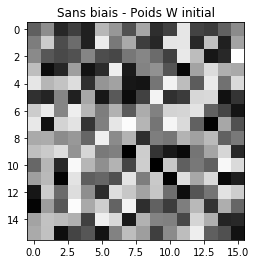

In [106]:
perceptron3 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.1, kernel=None)
perceptron3.fit(datax_train69,datay_train69)
print("Hinge-Erreur : train %f, test %f"% (perceptron3.score(datax_train69,datay_train69),perceptron3.score(datax_test69,datay_test69)))
plt.title("Sans biais - Poids W initial")
plt.imshow(perceptron3.w_init.reshape(16,16), cmap="gray")
plt.show()

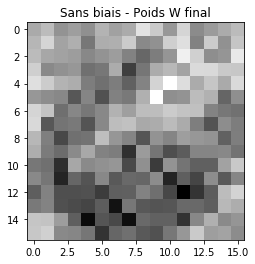

In [107]:
plt.title("Sans biais - Poids W final")
plt.imshow(perceptron3.w.reshape(16,16), cmap="gray")
plt.show()

In [104]:
datax_train18, datay_train18 = filter_data(datax_train, datay_train, 1,8)
datax_test18, datay_test18= filter_data(datax_test, datay_test, 1,8)

Hinge-Erreur : train 1.000000, test 0.871530


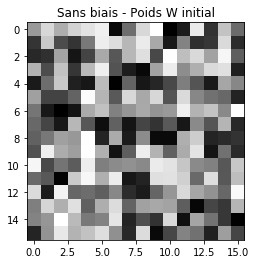

In [131]:
perceptron4 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.1, kernel=None)
perceptron4.fit(datax_train18,datay_train18)
print("Hinge-Erreur : train %f, test %f"% (perceptron4.score(datax_train18,datay_train18),perceptron4.score(datax_test18,datay_test18)))
plt.title("Sans biais - Poids W initial")
plt.imshow(perceptron4.w_init.reshape(16,16), cmap="gray")
plt.show()

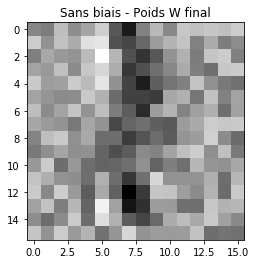

In [110]:
plt.title("Sans biais - Poids W final")
plt.imshow(perceptron4.w.reshape(16,16), cmap="gray")
plt.show()

In [127]:
datax_train6, datay_train6 = filter_dataOne(datax_train, datay_train, 6)
datax_test_no6, datay_test_no6= filter_dataSet(datax_test, datay_test, 6)

In [130]:
datay_test_no6

array([1, 1, 1, ..., 1, 1, 1])

Hinge-Erreur : train 1.000000, test 0.044638


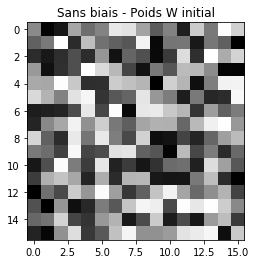

In [132]:
perceptron5= Perceptron(hinge,hinge_g,max_iter=1000,eps=0.1, kernel=None)
perceptron5.fit(datax_train6,datay_train6)
print("Hinge-Erreur : train %f, test %f"% (perceptron5.score(datax_train6,datay_train6),perceptron5.score(datax_test_no6,datay_test_no6)))
plt.title("Sans biais - Poids W initial")
plt.imshow(perceptron5.w_init.reshape(16,16), cmap="gray")
plt.show()

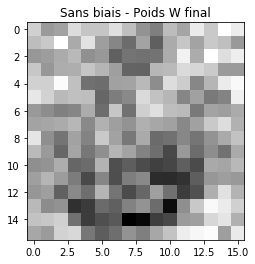

In [133]:
plt.title("Sans biais - Poids W final")
plt.imshow(perceptron5.w.reshape(16,16), cmap="gray")
plt.show()

In [63]:
steps=np.arange(50,5000,100)
train,test=[],[]
for i in steps:
    perceptron6= Perceptron(hinge,hinge_g,max_iter=i,eps=0.1, kernel=None)
    perceptron6.fit(datax_train69,datay_train69)
    train.append(perceptron6.score(datax_train69,datay_train69))
    test.append(perceptron6.score(datax_test69,datay_test69))


NameError: name 'datax_train69' is not defined

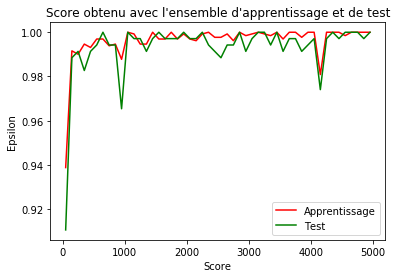

In [148]:
plt.plot(steps, train, 'r', label = "Apprentissage")
plt.plot(steps, test, 'g', label = "Test")
plt.title("Score obtenu avec l'ensemble d'apprentissage et de test")
plt.xlabel("Score")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

Données 2D et projection

Hinge-Erreur : train 0.985000, test 0.990000


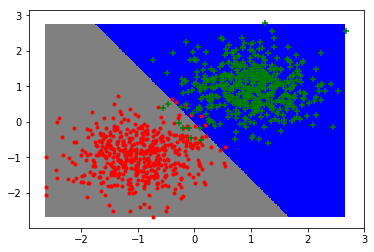

In [153]:
perceptron7 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.1, kernel=None)
perceptron7.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron7.score(trainx,trainy),perceptron7.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron7.predict,200)
plot_data(trainx,trainy)

bias detected
(1, 5)
(1000, 5)
Hinge-Erreur : train 0.903000, test 0.901000


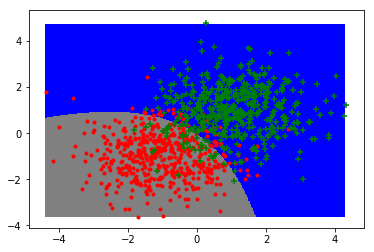

In [36]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
perceptron8 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="bias")
perceptron8.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron8.score(trainx,trainy),perceptron8.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron8.predict,200)
plot_data(trainx,trainy)


In [14]:
def plot_perceptron(trainx,trainy,testx,testy, perceptron):
    perceptron.fit(trainx,trainy)
    print("Erreur : train %f, test %f"% (perceptron.score(trainx,trainy),perceptron.score(testx,testy)))
    plt.figure()
    plot_frontiere(trainx,perceptron.predict,200)
    plot_data(trainx,trainy)

kernel  detected
Hinge-Erreur : train 0.997000, test 0.994000


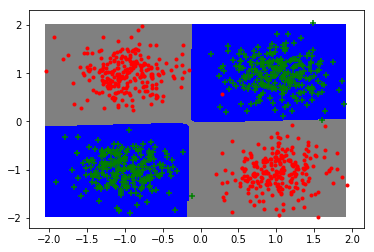

In [20]:
trainx,trainy = gaussienne(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.1)
testx,testy =  gaussienne(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.1)
perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="bias")
perceptron9.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron9.score(trainx,trainy),perceptron9.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron9.predict,200)
plot_data(trainx,trainy)


In [65]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

sigmas=np.arange(0.1,1,0.05)
resultsTrain=[]
resultsTest=[]

for i in range(len(sigmas)):
    perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel=None, sigma=sigmas[i],typeUp='batch')
    k=perceptron9.fit(trainx,trainy)
    t=perceptron9.score(trainx,trainy)
    resultsTrain.append(perceptron9.score(trainx,trainy))
    resultsTest.append(perceptron9.score(testx,testy))
    


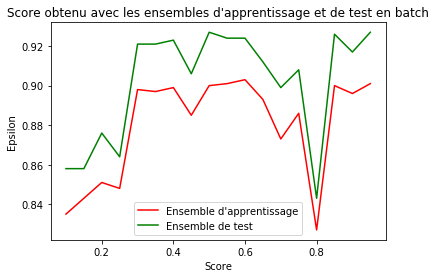

In [66]:
plt.plot(sigmas, resultsTrain, 'r', label="Ensemble d'apprentissage")
plt.plot(sigmas, resultsTest, 'g',label="Ensemble de test")
plt.title("Score obtenu avec les ensembles d'apprentissage et de test en batch")
plt.xlabel("Score")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

In [67]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

sigmas=np.arange(0.1,1,0.05)
resultsTrain=[]
resultsTest=[]

for i in range(len(sigmas)):
    perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel=None, sigma=sigmas[i],typeUp='stochastique')
    k=perceptron9.fit(trainx,trainy)
    t=perceptron9.score(trainx,trainy)
    resultsTrain.append(perceptron9.score(trainx,trainy))
    resultsTest.append(perceptron9.score(testx,testy))
    

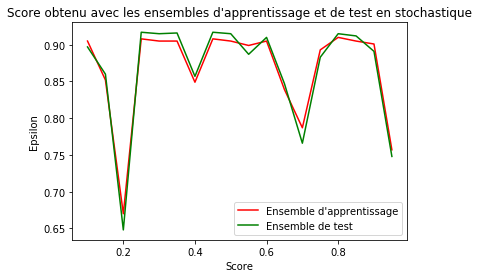

In [70]:
plt.plot(sigmas, resultsTrain, 'r', label="Ensemble d'apprentissage")
plt.plot(sigmas, resultsTest, 'g',label="Ensemble de test")
plt.title("Score obtenu avec les ensembles d'apprentissage et de test en stochastique")
plt.xlabel("Score")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

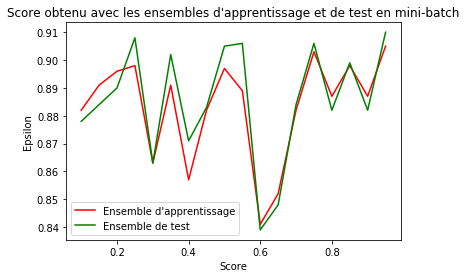

In [72]:
plt.plot(sigmas, resultsTrain, 'r', label="Ensemble d'apprentissage")
plt.plot(sigmas, resultsTest, 'g',label="Ensemble de test")
plt.title("Score obtenu avec les ensembles d'apprentissage et de test en mini-batch")
plt.xlabel("Score")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

In [71]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

sigmas=np.arange(0.1,1,0.05)
resultsTrain=[]
resultsTest=[]

for i in range(len(sigmas)):
    perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel=None, sigma=sigmas[i],typeUp='mini')
    k=perceptron9.fit(trainx,trainy)
    t=perceptron9.score(trainx,trainy)
    resultsTrain.append(perceptron9.score(trainx,trainy))
    resultsTest.append(perceptron9.score(testx,testy))
    

kernel  detected: bias3D
Hinge-Erreur : train 0.496000, test 0.501000


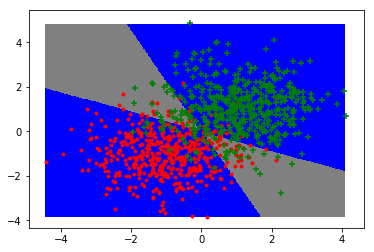

In [54]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
perceptron8 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="bias3D")
data_projected,w=perceptron8.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron8.score(trainx,trainy),perceptron8.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron8.predict,200)
plot_data(trainx,trainy)

In [74]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
perceptron8 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="gauss")
r=perceptron8.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron8.score(trainx,trainy),perceptron8.score(testx,testy)))


kernel  detected: gauss


/home/opt/anacoda/anacoda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/opt/anacoda/anacoda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


Hinge-Erreur : train 0.000000, test 0.000000


In [72]:

w

array([[7.99397066e-01, 3.52945734e-01, 4.92320332e-01, 1.64346975e-01,
        1.80800536e-01, 6.11540059e-01, 7.04332194e-01, 5.34395907e-02,
        2.18688670e-01, 2.15416897e-01, 7.10363083e-01, 6.48427154e-02,
        7.06129981e-01, 9.44839248e-01, 8.15315982e-01, 4.73178263e-01,
        3.79196950e-01, 4.06883443e-01, 4.22503528e-01, 7.11651445e-01,
        2.97709156e-01, 4.90315787e-01, 1.98982167e-01, 8.33140109e-01,
        2.95372460e-01, 1.59091773e-01, 2.97348387e-02, 8.52458619e-01,
        7.40899998e-01, 1.85300936e-01, 3.44801985e-01, 2.24174153e-01,
        5.70062973e-01, 5.86815775e-01, 7.25702640e-01, 4.35586392e-01,
        3.11942455e-01, 1.32839179e-01, 7.78893451e-01, 6.16663734e-01,
        3.48576086e-01, 8.63073041e-01, 7.71849453e-01, 1.14656472e-01,
        3.23104027e-01, 7.21369991e-01, 1.92721315e-01, 7.86054255e-01,
        5.86196610e-01, 8.54149261e-01, 9.49340399e-01, 1.87601281e-01,
        8.45802885e-02, 9.25437838e-01, 4.16650843e-01, 2.277478